# Vehicle Detection Project

### The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, a color transform can be applied and append binned color features, as well as histograms of color, to HOG feature vector.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
The feature extraction and SVM classifier training was done in three steps:
1. Data preprocessing - in order to train SVM classifier I used provided dataset of car and non-car images. The dataset has a relatively small size and can be efficiently processed in RAM. Therefore, I did not implement any methods (generators) for on the fly data processing and rather focused on sequential loading the dataset and preprocessing. The datset consists of 17,770 samples (208Mb). The second code cell describes the procedure of loading the dataset into memory.
2. Extract features - convert all images into feature vectors. As it is unclear in the beginning what is the best combination of features for car classifier, I started with hog classifier first. The third code cell illustrates the process of converting an images into a hog features. The fourth code cell applies feature extraction pipeline to the dataset.

3. Train SVM classifier

**Data preprocessing:**

In [1]:
# Load images
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm_notebook
from sys import getsizeof
from skimage.feature import hog
import numpy as np
import cv2, os
%matplotlib inline
from ClassifierTrainingPipeline import load_imgs, get_hog_features, img2features
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.svm import LinearSVC

In [2]:
path_to_car_samples = 'Data/vehicles'
path_to_noncar_samples = 'Data/non-vehicles'

car_samples = load_imgs(path_to_car_samples)
noncar_samples = load_imgs(path_to_noncar_samples)

# Report dataset stats
print("Total number of samples loaded:", car_samples.shape[0]+noncar_samples.shape[0])

  1%|          | 93/8792 [00:00<00:09, 926.02it/s]

Begin image loading process...


100%|██████████| 8792/8792 [00:09<00:00, 949.61it/s] 



8792 images were loaded. Total size of the dataset is 103.0Mb. Dataset shape: 1 (8792, 64, 64, 3)


  1%|          | 95/8968 [00:00<00:09, 949.76it/s]

Begin image loading process...


100%|██████████| 8968/8968 [00:08<00:00, 1060.81it/s]



8968 images were loaded. Total size of the dataset is 105.0Mb. Dataset shape: 1 (8968, 64, 64, 3)
Total number of samples loaded: 17760


**Extract Features**
    1. HOG

/Users/aponamaryov/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Original image size: (64, 64)
Fearues shape: (7, 7, 2, 2, 9)


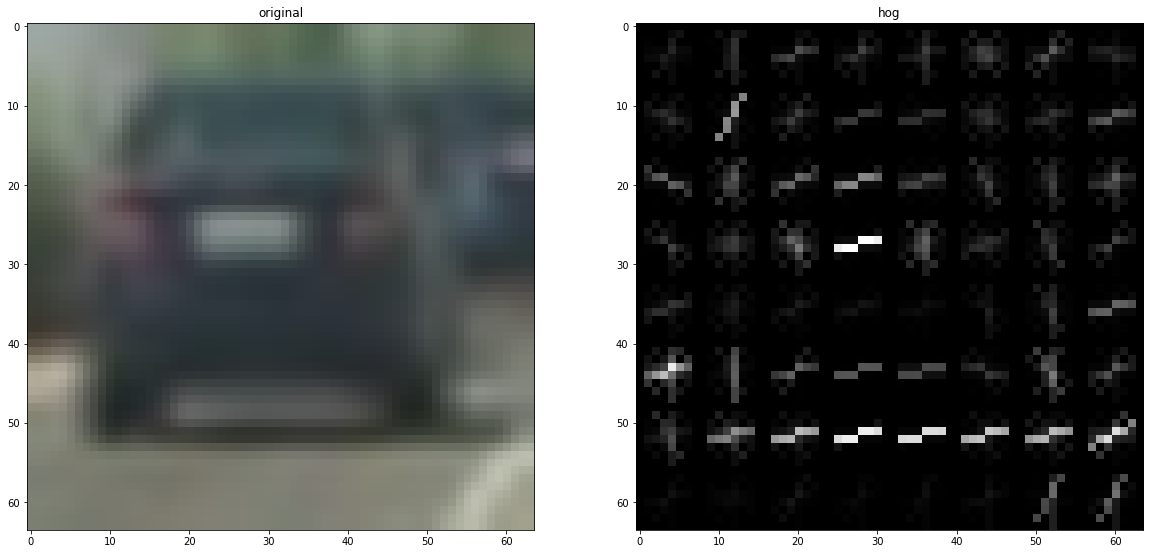

In [3]:
from skimage.feature import hog
img = car_samples[0]
features, hog_image = hog(cv2.cvtColor(car_samples[0], cv2.COLOR_RGB2GRAY), orientations=9, pixels_per_cell=(8, 8),
                                       cells_per_block=(2, 2), transform_sqrt=False, visualise=True, feature_vector=False)
print("Original image size:", img.shape[:-1])
print("Fearues shape:", features.shape)
f, s = plt.subplots(1, 2, figsize=(20, 10))
s[0].set_title("original")
s[0].imshow(img)
s[1].set_title("hog")
s[1].imshow(hog_image, cmap="gray")
plt.show()

    2. Color Features

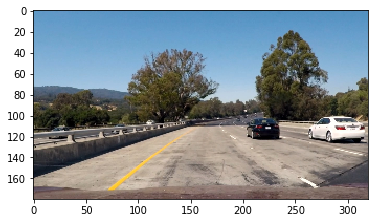

In [4]:
from ClassifierTrainingPipeline import cvtColor
from ipywidgets import interact
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
test_img_path = "test_images/test1.jpg"
img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (320, 180))
plt.imshow(img)

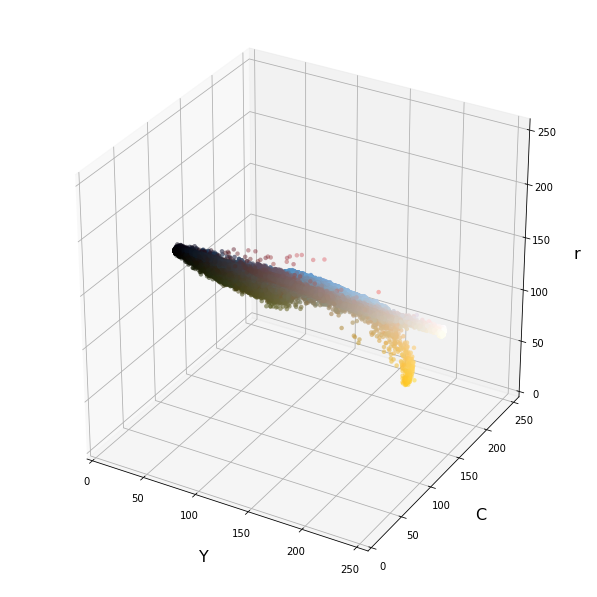

<function __main__.f>

In [5]:
def f(color):
    im = cvtColor(img, color)
    rgb_img0to1 = img.astype(np.float32)/255
    
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    ax.set_xlim([0,255])
    ax.set_xlabel(color[0], fontsize=16, labelpad=16)
    ax.set_ylim([0,255])
    ax.set_ylabel(color[1], fontsize=16, labelpad=16)
    ax.set_zlim([0,255])
    ax.set_zlabel(color[2], fontsize=16, labelpad=16)
    ax.scatter(im[:,:,0].ravel(), im[:,:,1].ravel(), im[:,:,2].ravel(), c=rgb_img0to1.reshape((-1, 3)), edgecolors='none')
    plt.show()

interact(f, color=["YCr", "HLS", "RGB", "HSV","LAB","YUV"])

In [6]:
feature_config = {"orientations": 9, "pix_per_cell": 8,
                  "cell_per_block": 2, "spatial_size": (32, 32),
                  "hist_bins": 32, "cmap":"YCr"}
image_processing = lambda im: img2features(im,
                                           orient=feature_config['orientations'],
                                           pix_per_cell=feature_config['pix_per_cell'],
                                           cell_per_block=feature_config['cell_per_block'],
                                           cmap=feature_config['cmap'],
                                           spatial_size=feature_config['spatial_size'],
                                           hist_bins=feature_config['hist_bins'])
car_features = np.array(list(map(image_processing, tqdm_notebook(car_samples))))
noncar_features = np.array(list(map(image_processing, tqdm_notebook(noncar_samples))))

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
/Users/aponamaryov/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


**Train Classifier**
    1. Convert data

In [7]:
# Convert Data sets into x
X = np.vstack((car_features, noncar_features)).astype(np.float64)
scaller = StandardScaler().fit(X)
X = scaller.transform(X)
# Create y (labels)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    2. Tune classifier.
In order to tune classifier it is important to answer 2 questions.

    A) What are the best settings for the parameters of the classifier
    B) Do we have enough data to train classifier well

For the purpose of this assignment we test LinearSVC classifier. This classifier depends only penalty parameter C. In order to find the best settings for C parameter, let's compare training and validation scores for various values of C (plot validation curve). To optimize performance of this process, I will limit the sample size to 1100 sampels.

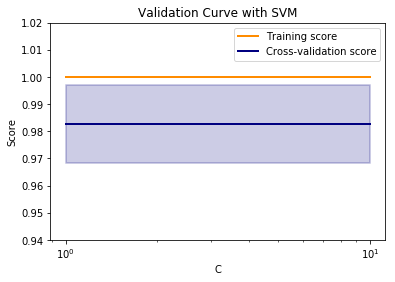

In [8]:
# Plot validation curve to check the SVM sensitivity to C
param_range = np.linspace(1,10,10).astype(np.int32)
train_scores, test_scores = validation_curve(LinearSVC(), X_train[:1100], y_train[:1100],
                                             param_name='C', param_range=param_range, cv=10,
                                             scoring="accuracy", n_jobs=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.94, 1.02)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Based on the results of the validation curve analysis presented below, I conclude that LinearSVC classifier is not sensetive to the value of C parameter. Therefore, I suggest to use default C value = 1.

As the next step, it is important to check if we have valid amount of data to train our classifier. For this purpose I will analyze the performance of training and validation scores on various dataset sizes (Learning Curve analysis).

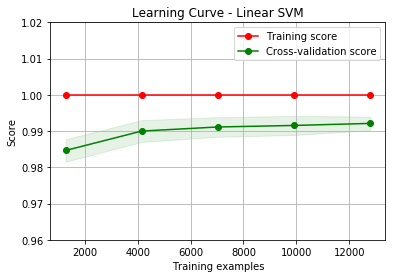

In [9]:
# Plot learning curve to check sufficiency of the data

classifier = LinearSVC()
plt.figure()
plt.title("Learning Curve - Linear SVM")
plt.ylim([0.96, 1.02])
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(
    classifier, X_train, y_train, n_jobs=2, train_sizes=np.linspace(.1, 1.0, 5), cv=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()


Based on the results of Learning curve analysis, I conclude that our dataset is sufficient to train LinearSVC classifier. Based on the plot presented above, one can observe that the improvement of validation score plateaued at 10,000 samples (as oppose to 17,770 samples available in our dataset).

The last step is to train our classifier and to analyze it's performance. For the analysis of classifier's performance I will use 3 metrics:
- accuracy - sum of true positives and negatives over the total number of elements.
- recall - Percentage of ground truth examples identified correctly
- precision - share of predictions was correct

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

classifier = LinearSVC()
classifier.fit(X_train, y_train)
y_ = classifier.predict(X_test)

In [11]:
print("Linear SVM demostrates the following results:")
cfm = confusion_matrix(y_test, y_)
print("Classifier accuracy - {:.2f}%".format(accuracy_score(y_test, y_)*100))
print("Classifier recall - {:.2f}%".format(recall_score(y_test, y_)*100))
print("Classifier precision - {:.2f}%".format(precision_score(y_test, y_)*100))
print("Confusion matrix:")
print(cfm)

import pickle
pipeline = {'scaller': scaller,
           'classifier': classifier,
           'feature_config': feature_config}
with open("pipeline.p", "wb") as f:
    pickle.dump(pipeline, f)

Linear SVM demostrates the following results:
Classifier accuracy - 99.16%
Classifier recall - 99.08%
Classifier precision - 99.19%
Confusion matrix:
[[1807   14]
 [  16 1715]]


Based on the results presented above I conclude that our classifier is well balanced and can discriminate cars vs. other objects with high precision.

As the next step I will use this classifier to detect and localise vehicles in images and video.